# Wind Turbine Fault Detection and Classification

NAME: Jean Pasato
RIN: 661955756

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
from keras.layers import Dense
from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import (f_classif, SelectKBest)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
# Loading dataset
scada_data = pd.read_csv('scada_data.csv')
fault_data = pd.read_csv('fault_data.csv')
status_data = pd.read_csv('status_data.csv')

# Checking Data

Each dataset will be checked for any "NA" values or duplicates in an effort to minimize outliers.

In [3]:
# Screen for missing values in the dataset
null1 = scada_data[scada_data.isnull().any(axis = 1)].shape[0]
null2 = fault_data[fault_data.isnull().any(axis = 1)].shape[0]
null3 = status_data[status_data.isnull().any(axis = 1)].shape[0]
nulls = [null1, null2, null3]
for i in nulls:
    print("Number of missing values in the dataframe:", nulls[i])

# Screen for duplicates in the dataset
dup1 = sum(scada_data.duplicated())
dup2 = sum(fault_data.duplicated())
dup3 = sum(status_data.duplicated())
dups = [dup1, dup2, dup3]
for i in dups:
    print("Number of duplicate rows:", dups[i] )

Number of missing values in the dataframe: 0
Number of missing values in the dataframe: 0
Number of missing values in the dataframe: 0
Number of duplicate rows: 0
Number of duplicate rows: 0
Number of duplicate rows: 0


# Fault and Status Grouping

The fault data classifications will be grouped together based on five different fault types:
1. AF - Malfunction Aircooling
2. EF - Excitation Error
3. FF - Feeding Fault
4. GF - Generator Heating Fault
5. MF - Mains Failure

Similarly, status data types will be group based on the StatusText output from the SCADA collection system.

In [4]:
fault_types = fault_data.groupby('Fault')
fault_types = fault_types.agg({'count'})['DateTime']
display(fault_types)

statuses = status_data.groupby(['StatusText', 'FullStatus'])
statuses = statuses.agg({'count'})['DateTime']
display(statuses)

,count
Fault,
AF,62
EF,174
FF,254
GF,43
MF,20


,,count
StatusText,FullStatus,
Air gap monitoring : Sensor 1 blade C,72 : 301,1
Cable twisted : Left (2-3 turns),21:01,1
Cable twisted : Right (2-3 turns),21:02,11
Calibration of load control,0:05,68
Data bus error (Timeout) : Fan inverter,304:56:00,1
Data bus error all inverters,204:00:00,5
Data bus error blade control (timeout) : Blade load control B,307:14:00,1
Excitation error : Overvoltage DC-link,80:21:00,84
Feeding control bus error (Bus-Off) : I/O-board control cabinet,301 : 81,3


In [5]:
# Fix Sub Status from 2 to 1 where Status Text = 'Lack of wind : Wind speed to low' 
status_data.loc[status_data.SubStatus == 2, 'SubStatus'] = 1
status_data.loc[status_data.FullStatus == '2 : 2', 'FullStatus'] = '2 : 1' # Change the value for FullStatus as well

# Fix Main Status from 66 to 62 (66 is the only value) and change 32 into 919 for Sub Status
status_data.loc[status_data.MainStatus == 66, 'MainStatus'] = 62
status_data.loc[status_data.SubStatus == 32, 'SubStatus'] = 919
status_data.loc[status_data.FullStatus == '66 : 32', 'FullStatus'] = '62 : 919'

# Combining Datasets

First, the number of matching datapoints will be calculated between the 
scada data and the status data. The fault and status datasets will combine with the scada dataset to develop a large dataset for classification. Once the combined dataset is achieved, unnecessary columns will be removed for analysis purposes.

In [6]:
scada_extended = scada_data.merge(status_data, how = 'inner', on = 'DateTime',  )
scada_extended

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Inverter averages,Inverter std dev,MainStatus,SubStatus,FullStatus,StatusText,T,Service,FaultMsg,Value0
0,5/10/2014 19:59,1399769984,0,10.800000,25.000000,3.3,0.03,0.62,0.00,0,...,25.090910,1.136182,62,3,62:03:00,Feeding fault : Load shedding,6,False,False,12.2
1,5/10/2014 19:59,1399769984,0,10.800000,25.000000,3.3,0.03,0.62,0.00,0,...,25.090910,1.136182,80,21,80:21:00,Excitation error : Overvoltage DC-link,6,False,False,12.2
2,5/11/2014 12:50,1399830656,0,8.300000,14.900000,1.8,0.01,0.11,0.00,0,...,23.363636,1.026911,21,1,21:02,Cable twisted : Right (2-3 turns),1,False,False,4.9
3,5/11/2014 19:29,1399854592,0,7.300000,14.700000,1.5,0.01,0.11,0.00,0,...,24.727272,0.904534,0,1,0:01,Turbine starting,1,False,False,8.5
4,5/12/2014 1:41,1399876864,0,5.500000,10.100000,1.4,0.00,0.08,0.00,0,...,24.272728,1.103713,62,701,62 : 701,Feeding fault : Overload chopper inverter 1,6,False,False,8.0
5,5/12/2014 2:40,1399880448,0,7.100000,9.700000,1.8,0.00,0.00,0.00,0,...,23.818182,0.981650,0,1,0:02,Turbine operational,1,False,False,10.3
6,5/12/2014 3:40,1399884032,0,3.900000,8.300000,1.3,0.00,0.03,0.00,0,...,23.454546,0.934199,0,1,0:01,Turbine starting,1,False,False,8.6
7,5/12/2014 4:40,1399887616,0,6.000000,9.300000,1.5,0.00,0.04,0.00,0,...,23.454546,0.934199,0,0,0:00,Turbine in operation,1,False,False,9.5
8,6/9/2014 14:09,1402340992,0,10.100000,12.400000,7.1,13.65,14.36,12.54,2246,...,35.454544,1.507557,0,1,0:02,Turbine operational,1,False,False,2.3
9,6/9/2014 14:09,1402340992,0,10.100000,12.400000,7.1,13.65,14.36,12.54,2246,...,35.454544,1.507557,0,1,0:01,Turbine starting,1,False,False,2.4


In [7]:
data = scada_data.merge(fault_data, on = 'Time', how = 'outer')
data[-data.isna().any(axis = 1)]

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,5/14/2014 14:39,1400096384,0,5.7,7.400000,4.1,9.98,10.23,9.72,0,...,27,17,26,35,34,2501,25.818182,0.603023,2014-05-14 14:39:44,GF
1946,5/14/2014 14:50,1400097024,0,6.4,8.600000,2.7,4.12,10.71,0.70,0,...,27,17,26,35,34,2501,26.090910,0.943880,2014-05-14 14:50:24,GF
1947,5/14/2014 14:58,1400097536,0,5.6,7.500000,4.0,9.99,10.20,9.80,0,...,27,17,26,35,34,2501,26.454546,0.820200,2014-05-14 14:58:56,GF
1948,5/14/2014 15:09,1400098176,0,5.3,6.600000,4.1,9.98,10.17,9.79,0,...,27,18,26,35,34,2501,26.181818,0.873863,2014-05-14 15:09:36,GF
1949,5/14/2014 15:20,1400098816,0,5.1,7.200000,3.8,9.99,10.17,9.80,0,...,28,18,26,35,34,2501,26.181818,0.981650,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,1/14/2015 23:00,1421298048,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,...,24,8,29,35,57,3050,25.909090,1.814086,2015-01-14 23:00:48,AF
37076,1/14/2015 23:09,1421298560,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,...,23,7,22,35,57,3050,28.181818,1.834022,2015-01-14 23:09:20,AF
37218,1/15/2015 22:50,1421383808,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,...,21,5,21,28,42,3050,20.909090,1.300350,2015-01-15 22:50:08,AF
37219,1/15/2015 23:00,1421384448,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,...,20,5,21,28,42,3050,20.909090,1.300350,2015-01-15 23:00:48,AF


In [8]:
# Drop unnecessary data
data = data.drop(columns = ['DateTime_x', 'Time', 'DateTime_y', 'Sys2inverter6cabinettemp.'])

data

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,6.9,9.4,2.9,0.00,0.02,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NaN
1,0,5.3,8.9,1.6,0.00,0.01,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NaN
2,0,5.0,9.5,1.4,0.00,0.04,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NaN
3,0,4.4,8.3,1.3,0.00,0.08,0.00,0,0,0,...,21,25,12,14,24,34,2501,25.272728,1.103713,NaN
4,0,5.7,9.7,1.2,0.00,0.05,0.00,0,0,0,...,21,25,12,14,23,34,2501,25.272728,1.103713,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,0,3.9,5.5,2.2,6.75,7.40,6.01,147,277,46,...,23,28,9,17,27,35,3050,24.454546,3.474583,NaN
49130,0,3.9,5.6,2.9,6.64,7.06,6.33,128,191,82,...,23,28,9,17,27,35,3050,24.454546,3.445683,NaN
49131,0,4.2,6.7,2.6,7.18,8.83,6.22,163,329,72,...,23,28,9,18,27,34,3050,24.363636,3.413876,NaN
49132,0,4.1,6.6,2.7,7.02,7.94,6.20,160,344,67,...,23,28,9,17,27,34,3050,24.000000,3.376389,NaN


In [9]:
# We will classify any data points that have an "NAN" value as a "not faulty" data point
# "Not Faulty" - NF
data['Fault'] = data['Fault'].replace(np.nan, 'NF')

In [10]:
data_nf = data[data.Fault == 'NF'].sample(5000, random_state=123)
data_faulty = data[data.Fault != 'NF']
data = pd.concat((data_nf, data_faulty), axis=0).reset_index(drop=True)
display(data)

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,2027,721,...,21,26,10,20,27,36,3050,21.909090,1.300350,NF
1,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,272,165,...,30,35,19,26,35,42,3050,31.272728,2.686667,NF
2,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,3146,2273,...,25,27,12,28,36,58,3050,28.818182,2.272364,NF
3,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,2718,835,...,22,25,11,20,27,35,3050,22.000000,1.341641,NF
4,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,3144,2325,...,27,30,16,28,36,54,3050,30.909090,2.385563,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,2798,2417,...,21,24,8,29,35,57,3050,25.909090,1.814086,AF
5549,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,2746,0,...,21,23,7,22,35,57,3050,28.181818,1.834022,AF
5550,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,1914,1259,...,17,21,5,21,28,42,3050,20.909090,1.300350,AF
5551,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,1945,781,...,16,20,5,21,28,42,3050,20.909090,1.300350,AF


# Feature Scaling

In [11]:
# Scale data for binary classification

data_binary = data.replace(['AF', 'EF', 'FF', 'GF', 'MF'], 'F')
display(data_binary)

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,2027,721,...,21,26,10,20,27,36,3050,21.909090,1.300350,NF
1,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,272,165,...,30,35,19,26,35,42,3050,31.272728,2.686667,NF
2,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,3146,2273,...,25,27,12,28,36,58,3050,28.818182,2.272364,NF
3,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,2718,835,...,22,25,11,20,27,35,3050,22.000000,1.341641,NF
4,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,3144,2325,...,27,30,16,28,36,54,3050,30.909090,2.385563,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,2798,2417,...,21,24,8,29,35,57,3050,25.909090,1.814086,F
5549,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,2746,0,...,21,23,7,22,35,57,3050,28.181818,1.834022,F
5550,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,1914,1259,...,17,21,5,21,28,42,3050,20.909090,1.300350,F
5551,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,1945,781,...,16,20,5,21,28,42,3050,20.909090,1.300350,F


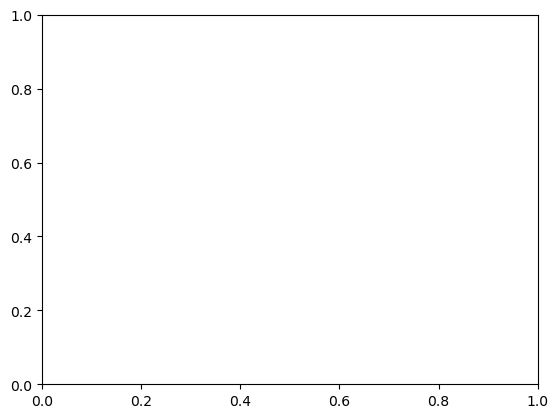

In [12]:
F = data_binary.Fault
F_t = data_binary.Fault.values.tolist()
le = LabelEncoder()
F_t = np.array(le.fit_transform(F_t))
x_t = np.arange(0, data_binary.shape[0])

fig, ax = plt.subplots()


In [13]:
# Splitting class from data by dropping 'Fault' identification
target_binary = data_binary.Fault
data_binary.drop('Fault', inplace=True, axis=1)

# Splitting datasets into an 80-20 split with train_test_split function
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(data_binary, target_binary, stratify=target_binary, test_size=0.2)

In [14]:
# Standardizing data for PCA
sc = StandardScaler()
X_b_train = sc.fit_transform(X_b_train)
X_b_test = sc.transform(X_b_test)

# Principal Component Analysis

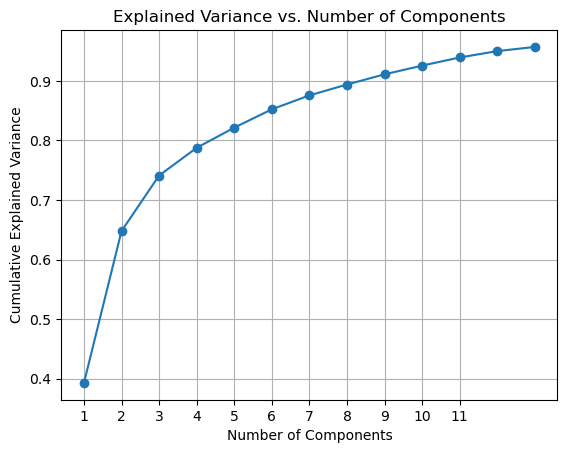

In [15]:
# Feature Extraction
pca = PCA(0.95)
fit_pca = pca.fit(X_b_train)
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratios)
PC_values = np.arange(pca.n_components_) + 1
plt.figure()
plt.plot(PC_values, cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, 12))
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

In [16]:
# Apply PCA on training and testing sets
X_PCA_train = pca.transform(X_b_train)
X_PCA_test = pca.transform(X_b_test)

# Models Used for Prediction

In [17]:
# Define Performance Metrics
scores = ['accuracy']

In [18]:
# Support Vector Machine
model_SVM = SVC(kernel='linear')

In [19]:
# Random Forest Classifier
model_RF = RandomForestClassifier(n_estimators=30, random_state=300)

In [20]:
# Artificial Neural Network

target = y_b_train.values.tolist()
label_encoder = LabelEncoder()
Y = np.array(label_encoder.fit_transform(target))
new_y_b_train = Y[:50000]


model_ANN = Sequential()
model_ANN.add(Dense(32, input_dim = 63, activation='relu'))
model_ANN.add(Dense(32, activation='relu'))
model_ANN.add(Dense(1, activation = 'sigmoid'))

model_ANN.summary()
model_ANN.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
history = model_ANN.fit(X_b_train, new_y_b_train, epochs=5, validation_split=0.3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2048      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
98/98 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2171 - val_loss: 0.0000e+00 - val_accuracy: 0.1073
Epoch 2/5
98/98 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0962 - val_loss: 0.0000e+00 - val_accuracy: 0.1073
Epoch 3/5
98/98 [=======

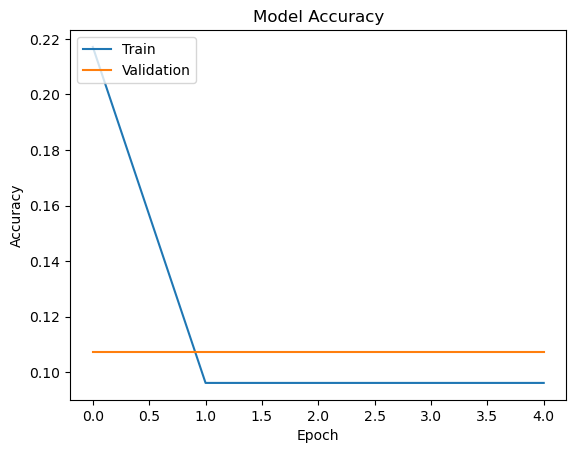

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
# Fitting SVM
SVM_b = model_SVM.fit(X_b_train, y_b_train)
SVM_predict_b = model_SVM.predict(X_b_test)

# Fitting Random Forest Classifier
RF_b = model_RF.fit(X_b_train, y_b_train)
RF_predict_b = model_RF.predict(X_b_test)


In [23]:
# PCA Binary Classification Dataset

# SVM with PCA
SVM_b_PCA = model_SVM.fit(X_PCA_train, y_b_train)
SVM_predict_b_PCA = model_SVM.predict(X_PCA_test)

# Random Forest Classifier with PCA
RF_b_PCA = model_RF.fit(X_PCA_train, y_b_train)
RF_predict_b_PCA = model_RF.predict(X_PCA_test)

# Fault Identification Evaluation

In [31]:
# Accuracy

print('SVM Accuracy Score:')
print("Binomial Classification dataset:", accuracy_score(SVM_predict_b, y_b_test))
print("Binomial Classification dataset after PCA:", accuracy_score(SVM_predict_b_PCA, y_b_test))
print()
print('Random Forest Accuracy Score:')
print("Binomial Classification dataset:", accuracy_score(RF_predict_b, y_b_test))
print("Binomial Classification dataset after PCA:", accuracy_score(RF_predict_b_PCA, y_b_test))

SVM Accuracy Score:
Binomial Classification dataset: 0.9513951395139514
Binomial Classification dataset after PCA: 0.9297929792979298

Random Forest Accuracy Score:
Binomial Classification dataset: 0.9675967596759676
Binomial Classification dataset after PCA: 0.9567956795679567


# Fault Classification

In [25]:
# Multiclass dataset

target = data.Fault
data.drop('Fault', inplace=True, axis=1)
data

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,2027,721,...,28,21,26,10,20,27,36,3050,21.909090,1.300350
1,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,272,165,...,37,30,35,19,26,35,42,3050,31.272728,2.686667
2,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,3146,2273,...,28,25,27,12,28,36,58,3050,28.818182,2.272364
3,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,2718,835,...,25,22,25,11,20,27,35,3050,22.000000,1.341641
4,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,3144,2325,...,30,27,30,16,28,36,54,3050,30.909090,2.385563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,2798,2417,...,27,21,24,8,29,35,57,3050,25.909090,1.814086
5549,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,2746,0,...,27,21,23,7,22,35,57,3050,28.181818,1.834022
5550,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,1914,1259,...,23,17,21,5,21,28,42,3050,20.909090,1.300350
5551,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,1945,781,...,23,16,20,5,21,28,42,3050,20.909090,1.300350


# SMOTE

Create a SMOTE to oversample the minority class, synthetically balancing the dataset.

In [26]:
sm = SMOTE(random_state=123)
data_SMOTE, target_SMOTE = sm.fit_resample(data, target)

In [27]:
# Split SMOTE datasets into training and testing sets

random.seed(123)
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(data_SMOTE, target_SMOTE, stratify=target_SMOTE, test_size=0.2 )

In [28]:
X_SMOTE_train = sc.fit_transform(X_SMOTE_train)
X_SMOTE_test = sc.transform(X_SMOTE_test)

# Random Forest Classifier Model Fitted
RF_SMOTE = model_RF.fit(X_SMOTE_train, y_SMOTE_train)
RF_predict_SMOTE = model_RF.predict(X_SMOTE_test)

In [29]:
print("Accuracy of SMOTE Binomial Classification dataset on the Random Forest Model:", accuracy_score(RF_predict_SMOTE, y_SMOTE_test))

Accuracy of SMOTE Binomial Classification dataset on the Random Forest Model: 0.9028333333333334


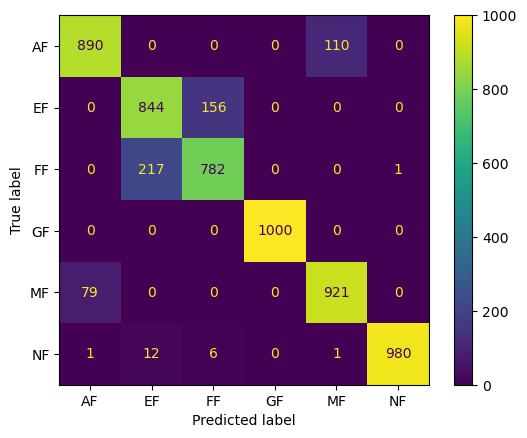

In [30]:
# Confusion Matrix

confusionmatrix = metrics.confusion_matrix(y_SMOTE_test, RF_predict_SMOTE)
confusionmatrix_display = metrics.ConfusionMatrixDisplay(confusionmatrix, display_labels=['AF', 'EF', 'FF', 'GF', 'MF', 'NF'])

confusionmatrix_display.plot()
plt.show()